In [ ]:
# file : rforest_pt.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Load and filter data

In [2]:
def prepare_weekly_city(df_raw, city_name):
    df_city = df_raw[df_raw["City"] == city_name].copy()
    df_city["Date"] = pd.to_datetime(df_city["Date"])
    df_city = df_city.set_index("Date").sort_index()

    agg_dict = {
        "Cases": "sum",
        "Precip": "sum",
        "Pressure": "mean",
        "Tmean": "mean",
        "Tmin": "mean",
        "Tmax": "mean",
        "Humidity": "mean",
        "Windspeed": "mean",
        "BI": "mean",
        "HI": "mean",
        "CI": "mean",
        "PopDensity_km2": "mean",
    }

    # 1) Weekly aggregation with regular weekly index
    df_weekly = df_city.resample("W").agg(agg_dict).asfreq("W")

    # 2) Handle cases (if any NaN after resample, treat as 0)
    df_weekly["Cases"] = df_weekly["Cases"].fillna(0)

    # 3) Weather interpolation
    weather_cols = ["Precip", "Pressure", "Tmean", "Tmin", "Tmax",
                    "Humidity", "Windspeed"]
    df_weekly[weather_cols] = (
        df_weekly[weather_cols]
        .interpolate(method="time")
        .ffill()
        .bfill()
    )

    # 4) Mosquito indices: carry-forward then backward
    index_cols = ["BI", "HI", "CI"]
    df_weekly[index_cols] = df_weekly[index_cols].ffill().bfill()

    return df_weekly


In [3]:
df_raw = pd.read_csv("../data/3_df_merged_cleaned.csv")
df_ks_weekly = prepare_weekly_city(df_raw, "Pingtung County")


## define lag feature

In [4]:
def add_lag_features(df, lag_cols, lags):
    df = df.copy()
    for col in lag_cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


In [5]:
lag_cols = ["Cases", "Tmean", "Tmin", "Tmax",
            "BI", "HI", "CI",
            "Precip", "Humidity"]

lags = [1, 2, 4, 8, 10, 11, 12, 15]


In [6]:
df_lagged = add_lag_features(df_ks_weekly, lag_cols, lags)

# Drop initial rows with NaN lag values
df_lagged = df_lagged.dropna().copy()

df_lagged.head()


,Cases,Precip,Pressure,Tmean,Tmin,Tmax,Humidity,Windspeed,BI,HI,...,Precip_lag12,Precip_lag15,Humidity_lag1,Humidity_lag2,Humidity_lag4,Humidity_lag8,Humidity_lag10,Humidity_lag11,Humidity_lag12,Humidity_lag15
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-18,0.0,0.16,1012.568571,24.894286,22.042857,28.614286,71.171429,4.375714,1.901955,1.728608,...,0.09,0.16,71.931429,66.398571,75.045714,70.364286,78.521429,74.665714,68.300000,73.770000
2010-04-25,0.0,0.72,1010.641429,26.024286,23.257143,29.371429,70.624286,3.425714,2.585933,2.062211,...,0.43,0.06,71.171429,71.931429,69.391429,76.614286,76.857143,78.521429,74.665714,66.098571
2010-05-02,0.0,1.08,1011.704286,24.602857,22.328571,27.157143,67.135714,3.420000,2.828756,1.997081,...,0.00,0.07,70.624286,71.171429,66.398571,77.894286,70.364286,76.857143,78.521429,59.665714
2010-05-09,0.0,0.16,1006.005714,27.188571,24.642857,30.242857,71.925714,2.392857,2.584999,2.003567,...,0.06,0.09,67.135714,70.624286,71.931429,71.105714,76.614286,70.364286,76.857143,68.300000
2010-05-16,0.0,0.14,1007.122857,27.382857,24.657143,30.714286,71.375714,2.337143,1.856738,1.516665,...,0.56,0.43,71.925714,67.135714,71.171429,75.045714,77.894286,76.614286,70.364286,74.665714


## Train test split by date

In [7]:
train = df_lagged.loc[df_lagged.index < "2022-01-01"].copy()
test  = df_lagged.loc[df_lagged.index >= "2022-01-01"].copy()

print(train.shape, test.shape)


(611, 84) (158, 84)


## Separate target and feature

In [8]:
y_train = train["Cases"].values
y_test  = test["Cases"].values

feature_cols = [c for c in df_lagged.columns if c != "Cases"]
#
X_train = train[feature_cols].values
X_test  = test[feature_cols].values 


## Build random forest 

In [9]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predict on the test set and compute metrics

In [10]:
y_pred = rf_model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("📊 Random Forest — Test Performance")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")


📊 Random Forest — Test Performance
MSE  : 8.8541
RMSE : 2.9756
MAE  : 1.2886
R²   : 0.8529


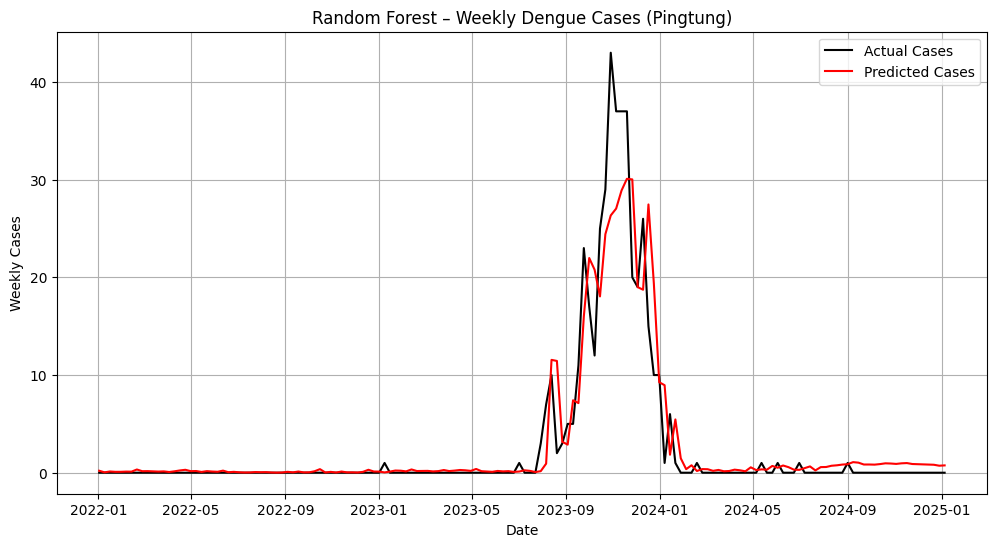

In [11]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual Cases", color="black")
plt.plot(test.index, y_pred, label="Predicted Cases", color="red")
plt.title("Random Forest – Weekly Dengue Cases (Pingtung)")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()



## Feature Importance analysis

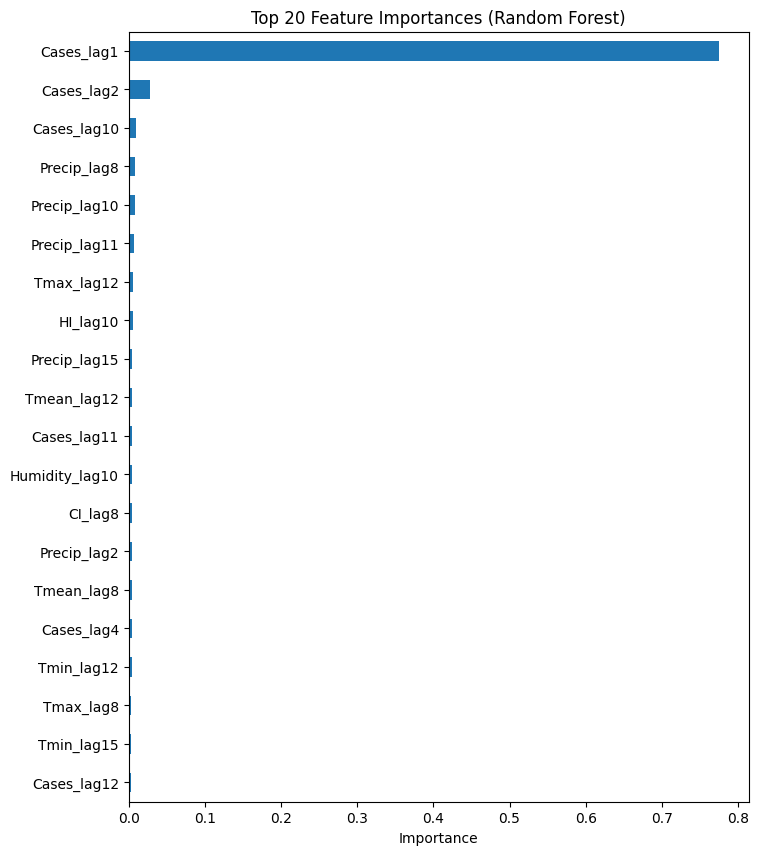

In [12]:
importances = rf_model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,10))
fi.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [13]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit


In [14]:
# time-series CV on the TRAIN ONLY (df_lagged before 2022)
tscv = TimeSeriesSplit(n_splits=5)


In [15]:
param_dist = {
    "n_estimators": [300, 500, 700],        # around your 500
    "max_depth": [None, 15, 25],            # None = no limit, 15/25 = mild regularization
    "min_samples_split": [2, 5],            # 2 (baseline) and slightly larger
    "min_samples_leaf": [1, 2],             # 1 (baseline) and slightly larger
    "max_features": [0.7, 1.0, "sqrt"],     # 1.0 ~ all features, try a bit less too
    "bootstrap": [True]                     # start with bootstrap=True (classic RF)
}


In [16]:
base_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)


In [17]:
random_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=50,                      # number of random combos to try
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("🔍 Starting Random Forest hyperparameter search...")
random_search.fit(X_train, y_train)
print("✅ Search done.")


🔍 Starting Random Forest hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=None, max_features=0.7, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=25, max_features=0.7, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=0.7, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=0.7, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=25, max_features=0.7, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=0.7, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=0.7, min_samples

In [18]:
print("Best MAE (CV):", -random_search.best_score_)
print("Best hyperparameters:")
for k, v in random_search.best_params_.items():
    print(f"  {k}: {v}")


Best MAE (CV): 1.765606419109454
Best hyperparameters:
  n_estimators: 700
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: 1.0
  max_depth: 15
  bootstrap: True


In [19]:
best_rf = random_search.best_estimator_

# Fit on all training weeks (before 2022)
best_rf.fit(X_train, y_train)


,n_estimators,700
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
y_pred = best_rf.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("📊 Tuned Random Forest — Test Performance")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


📊 Tuned Random Forest — Test Performance
MSE  : 8.697
RMSE : 2.949
MAE  : 1.243
R²   : 0.856


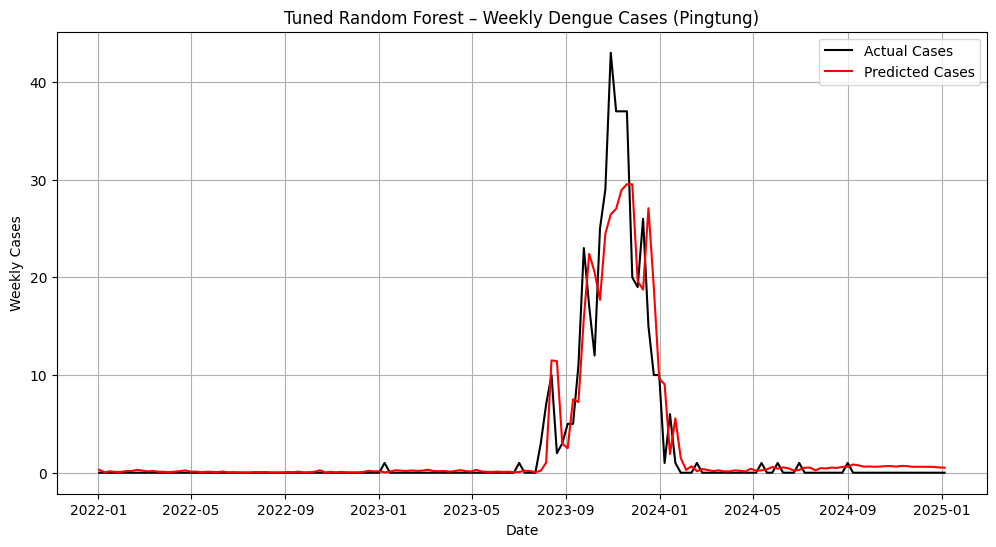

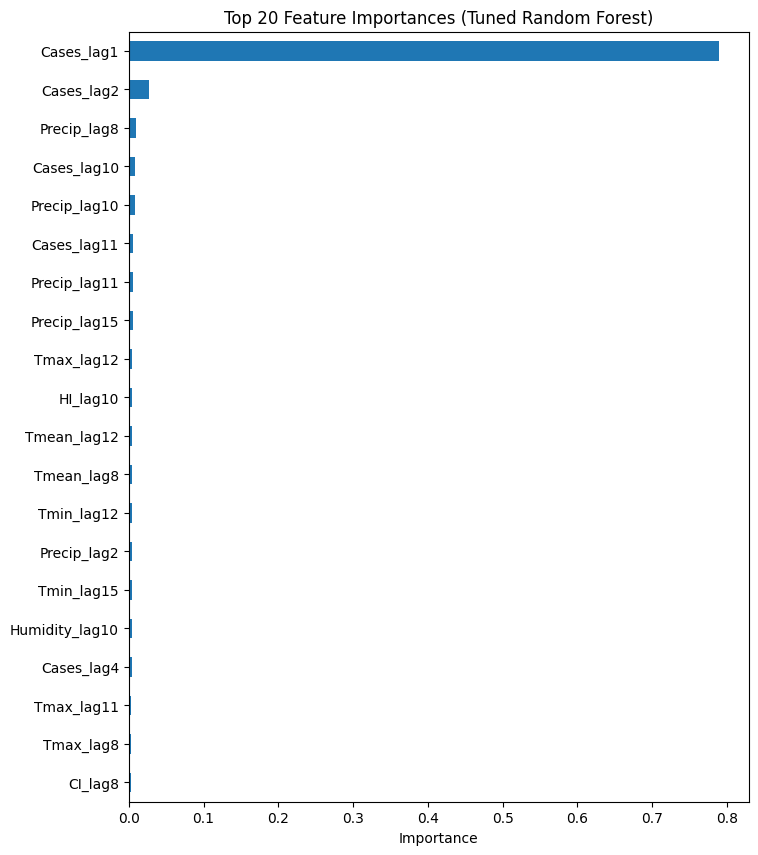

In [21]:
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual Cases", color="black")
plt.plot(test.index, y_pred, label="Predicted Cases", color="red")
plt.title("Tuned Random Forest – Weekly Dengue Cases (Pingtung)")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()

# Importance
importances = best_rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,10))
fi.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.show()


## Save Artifacts

In [22]:
# %% [markdown]
# ## Save artifacts for Streamlit

import os, json

# create folder if it doesn't exist
os.makedirs("../artifacts", exist_ok=True)

city_code = "pt"          # Pingtung
model_name = "rf"         # random forest

# 1) Save test predictions
pred_df = pd.DataFrame({
    "Date": test.index,   # weekly index
    "y_test": y_test,
    "y_pred": y_pred
})
pred_path = f"../artifacts/{model_name}_{city_code}_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("Saved predictions to", pred_path)

# 2) Save feature importance
fi_df = fi.to_frame(name="importance")
fi_path = f"../artifacts/{model_name}_{city_code}_feature_importance.csv"
fi_df.to_csv(fi_path)
print("Saved feature importance to", fi_path)

# 3) Save metrics
metrics = {
    "MSE": float(mse),
    "RMSE": float(rmse),
    "MAE": float(mae),
    "R2": float(r2),
}
metrics_path = f"../artifacts/{model_name}_{city_code}_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to", metrics_path)

# 4) (Optional) save best hyperparameters
best_params_path = f"../artifacts/{model_name}_{city_code}_best_params.json"
with open(best_params_path, "w") as f:
    json.dump(random_search.best_params_, f, indent=2)
print("Saved best params to", best_params_path)


Saved predictions to ../artifacts/rf_pt_predictions.csv
Saved feature importance to ../artifacts/rf_pt_feature_importance.csv
Saved metrics to ../artifacts/rf_pt_metrics.json
Saved best params to ../artifacts/rf_pt_best_params.json


In [23]:
import plotly.graph_objects as go

# --- Collect CV results into a DataFrame ---
cv = pd.DataFrame(random_search.cv_results_)

# convert from negative MAE (sklearn convention) back to positive MAE
cv["cv_mae"] = -cv["mean_test_score"]

print(cv[["params", "cv_mae"]].head())


                                              params    cv_mae
0  {'n_estimators': 700, 'min_samples_split': 5, ...  1.888435
1  {'n_estimators': 500, 'min_samples_split': 5, ...  1.808381
2  {'n_estimators': 500, 'min_samples_split': 5, ...  1.899180
3  {'n_estimators': 700, 'min_samples_split': 5, ...  1.799596
4  {'n_estimators': 700, 'min_samples_split': 2, ...  2.422936


In [24]:
# names in cv_results_ have "param_" prefix
x_param = "param_n_estimators"
y_param = "param_max_depth"

# drop rows where max_depth is None (can't plot as numeric)
cv_vis = cv[cv[y_param].notna()].copy()

# make sure they're numeric, not strings
cv_vis[x_param] = pd.to_numeric(cv_vis[x_param])
cv_vis[y_param] = pd.to_numeric(cv_vis[y_param])


In [25]:
# pivot: rows = max_depth, columns = n_estimators, values = CV MAE
pivot = (
    cv_vis.pivot_table(
        index=y_param,
        columns=x_param,
        values="cv_mae",
        aggfunc="mean",
    )
    .sort_index(axis=0)   # sort max_depth
    .sort_index(axis=1)   # sort n_estimators
)

# interpolate any missing combos so the surface is continuous
z = (
    pd.DataFrame(pivot)
    .interpolate(axis=1, limit_direction="both")  # across n_estimators
    .interpolate(axis=0, limit_direction="both")  # across max_depth
    .to_numpy()
)

x = pivot.columns.to_numpy()   # n_estimators
y_vals = pivot.index.to_numpy()  # max_depth


In [26]:
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y_vals)])

fig.update_layout(
    title="Random Forest CV MAE surface: n_estimators × max_depth (lower is better)",
    scene=dict(
        xaxis_title="n_estimators",
        yaxis_title="max_depth",
        zaxis_title="CV MAE",
    ),
    width=800,
    height=700,
)

fig.show()
